## Initiate Project

In [528]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")

RSEED = 42

In [529]:
# Read data
df_tanzania=pd.read_csv("data/Train.csv")

In [530]:
# split train-test data. We have dropped:
# "ID" as it is irrelevant for the case and 
# "most_impressing" as it is correlated with "purpose"

X = df_tanzania.drop(['total_cost','ID', "most_impressing"],axis=1)
y = df_tanzania.total_cost

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=RSEED)

In [531]:
# Build new data frame for EDA

df_tanzania_train = X_train.join(y_train)

## EDA

In [532]:
df_tanzania_train.columns

Index(['country', 'age_group', 'travel_with', 'total_female', 'total_male',
       'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'total_cost'],
      dtype='object')

In [533]:
# Check for empty values. We have them in "total_female", "total_male" and mostly in "travel_with"

df_tanzania_train.isnull().sum()

country                    0
age_group                  0
travel_with              833
total_female               1
total_male                 4
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
payment_mode               0
first_trip_tz              0
total_cost                 0
dtype: int64

In [534]:
# most of our features are categorical, besides four of them: 
# total_female, total_male, night_mainland, night_zanzibar and the total cost

df_tanzania_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3606 entries, 3075 to 860
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                3606 non-null   object 
 1   age_group              3606 non-null   object 
 2   travel_with            2773 non-null   object 
 3   total_female           3605 non-null   float64
 4   total_male             3602 non-null   float64
 5   purpose                3606 non-null   object 
 6   main_activity          3606 non-null   object 
 7   info_source            3606 non-null   object 
 8   tour_arrangement       3606 non-null   object 
 9   package_transport_int  3606 non-null   object 
 10  package_accomodation   3606 non-null   object 
 11  package_food           3606 non-null   object 
 12  package_transport_tz   3606 non-null   object 
 13  package_sightseeing    3606 non-null   object 
 14  package_guided_tour    3606 non-null   object 
 15  package

In [535]:
# Export unique values for all categorical features to analyze outside of VScode
unique_values = X_train.apply(lambda col: col.unique())
print('unique:',unique_values)
unique_values.to_csv('data/unique_Value_train_features.csv')

unique: country                  [SOUTH AFRICA, KENYA, POLAND, IRELAND, UNITED ...
age_group                                        [25-44, 1-24, 45-64, 65+]
travel_with              [nan, Spouse and Children, Spouse, Friends/Rel...
total_female             [0.0, 2.0, 1.0, 4.0, 6.0, 3.0, 7.0, 5.0, 10.0,...
total_male               [1.0, 2.0, 0.0, 3.0, 4.0, 5.0, 6.0, nan, 9.0, ...
purpose                  [Meetings and Conference, Leisure and Holidays...
main_activity            [Wildlife tourism, Beach tourism, Hunting tour...
info_source              [Friends, relatives, Radio, TV, Web, Travel, a...
tour_arrangement                               [Independent, Package Tour]
package_transport_int                                            [No, Yes]
package_accomodation                                             [No, Yes]
package_food                                                     [No, Yes]
package_transport_tz                                             [No, Yes]
package_sightseei

## Remove Outliers

<Axes: >

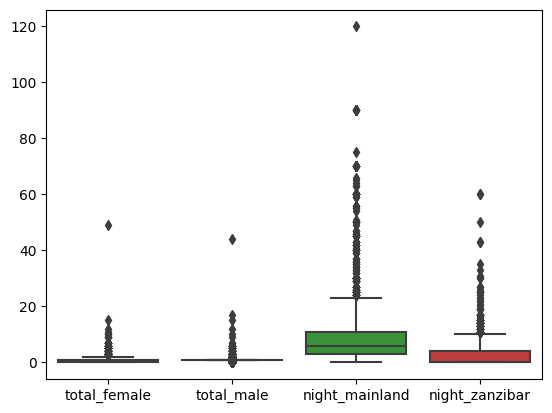

In [536]:
# Remove Outliers

sns.boxplot(df_tanzania_train.drop("total_cost", axis=1))

In [537]:
# Define function to print the whiskers of a boxplot

def calculate_whiskers(df, column):
    """
    Calculate the lower and upper whiskers for a specified column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to calculate whiskers for.

    Returns:
        tuple: (lower_whisker, upper_whisker)
    """
    # Get descriptive statistics for the column
    stats = df[column].describe()
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1

    # Calculate the lower whisker
    lower_whisker = max(
        df[column][df[column] >= (Q1 - 1.5 * IQR)].min(), 
        df[column].min()
    )
    
    # Calculate the upper whisker
    upper_whisker = min(
        df[column][df[column] <= (Q3 + 1.5 * IQR)].max(), 
        df[column].max()
    )
    
    return lower_whisker, upper_whisker

In [538]:
lower, upper = calculate_whiskers(df_tanzania_train, "night_mainland")
print(f"Upper Whisker night_mainland: {upper}")
lower, upper = calculate_whiskers(df_tanzania_train, "night_zanzibar")
print(f"Upper Whisker night_zanzibar: {upper}")
lower, upper = calculate_whiskers(df_tanzania_train, "total_female")
print(f"Upper Whisker total_female: {upper}")
lower, upper = calculate_whiskers(df_tanzania_train, "total_male")
print(f"Upper Whisker total_male: {upper}")
lower, upper = calculate_whiskers(df_tanzania_train, "total_cost")
print(f"Upper Whisker total_cost: {upper}")

Upper Whisker night_mainland: 23.0
Upper Whisker night_zanzibar: 10.0
Upper Whisker total_female: 2.0
Upper Whisker total_male: 1.0
Upper Whisker total_cost: 23601032.0


In [539]:
#Remove outliers (except from total_male, as we were missing a lot of data)
df_tanzania_train = df_tanzania_train.query("night_mainland <= 23")
df_tanzania_train = df_tanzania_train.query("night_zanzibar <= 10")
df_tanzania_train = df_tanzania_train.query("total_female <= 2")
df_tanzania_train = df_tanzania_train.query("total_cost <= 21810040.0")

## Some Plots

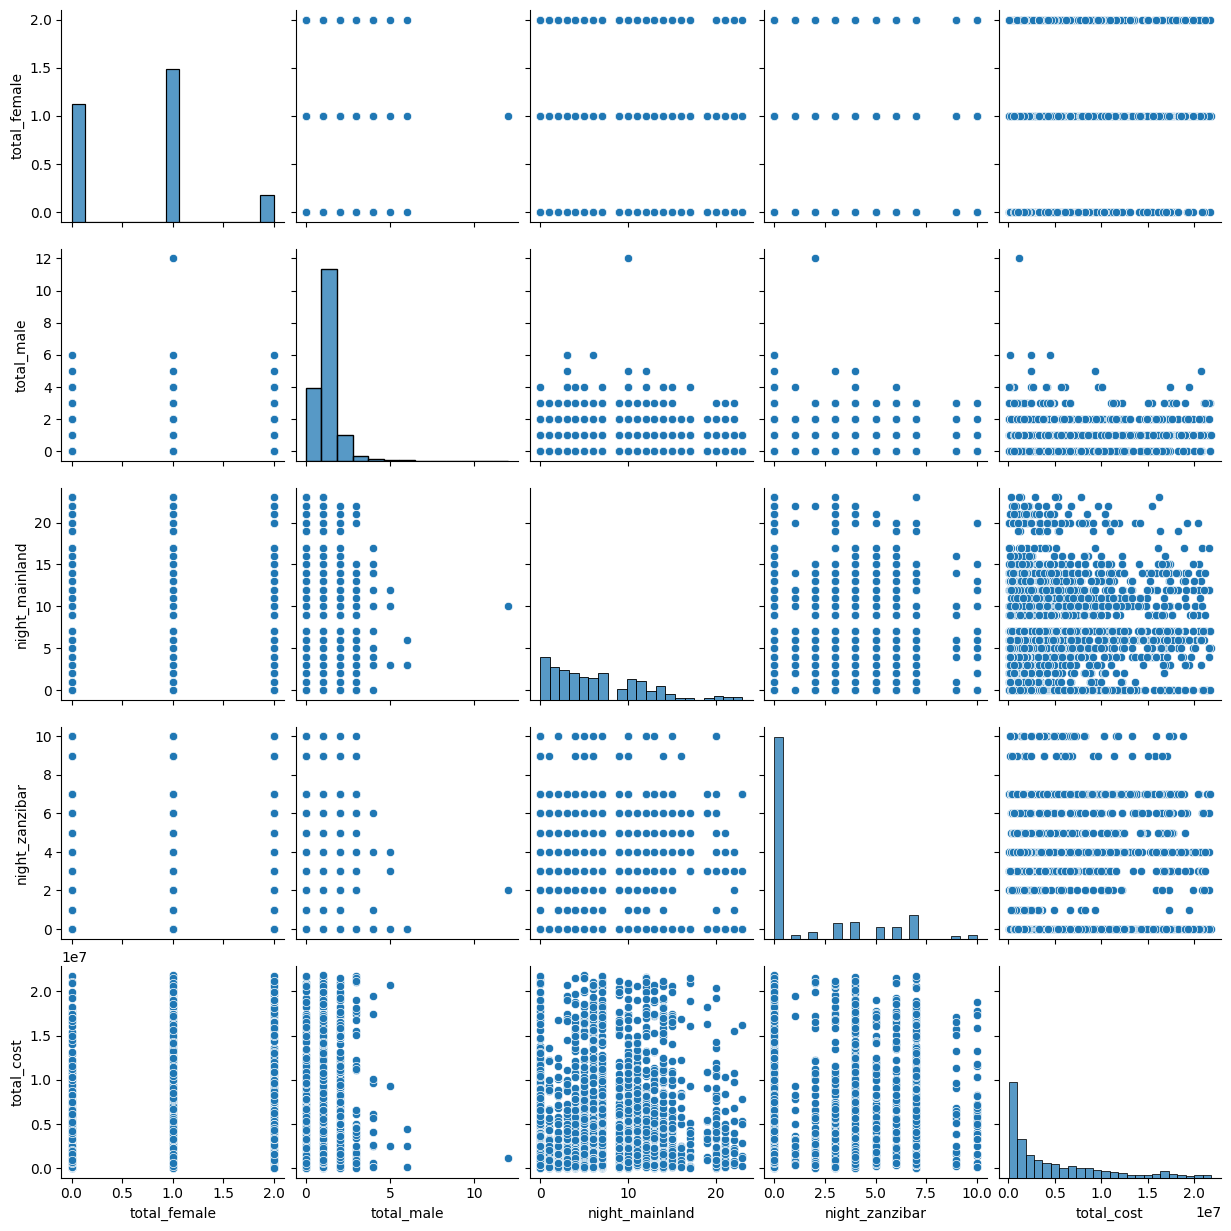

In [540]:
sns.pairplot(df_tanzania_train)

<Axes: >

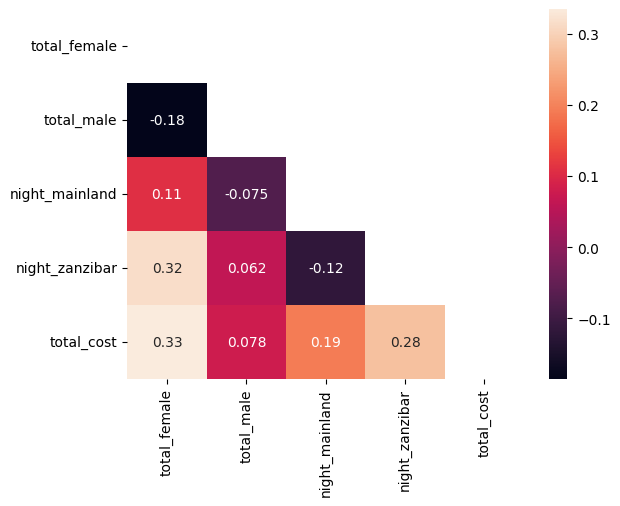

In [541]:
correlations = df_tanzania_train.corr(numeric_only=True)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlations, annot=True, mask=mask)

# Some notes:
# if women travel, then more money is spent
# more money is spent in zanzibar than in the mainland
# men travelling tend to spend less money (although this looks like values related to the fact that mostly men travel alone for business, therefore they would be not included in "total_men" - see next plot)



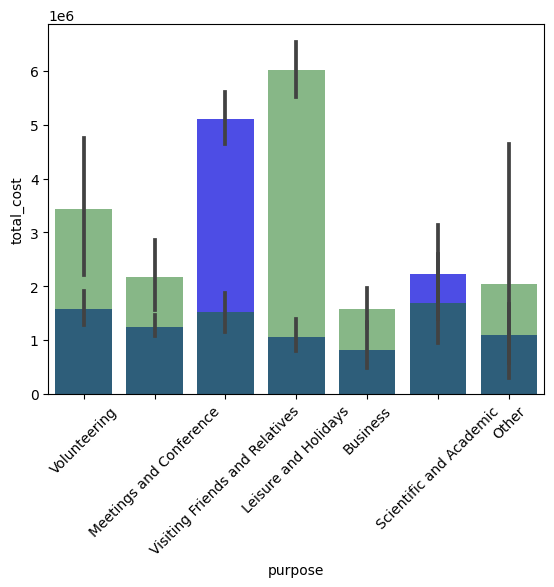

In [542]:
sns.barplot(df_tanzania_train.query("total_female==0"), x="purpose", y="total_cost", color = "blue", alpha=0.8)
sns.barplot(df_tanzania_train.query("total_male==0"), x="purpose", y="total_cost", color = "green", alpha=0.5)
plt.xticks(rotation=45)


plt.show()

# Women spend more money in almost all purposes - except for Business and Meetings & Conferences


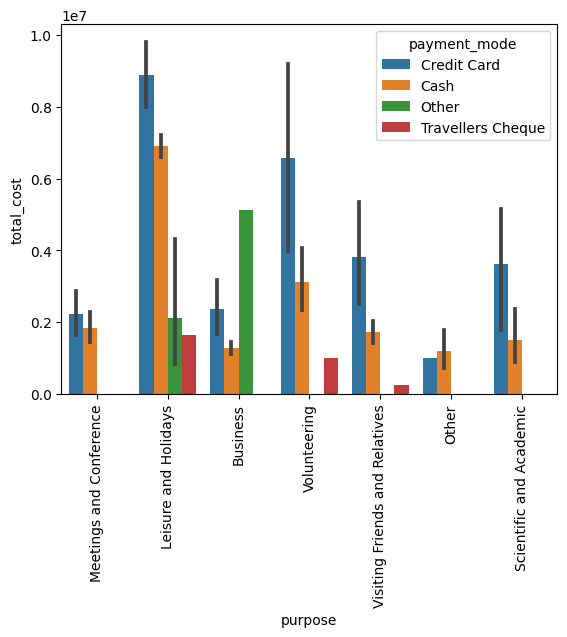

In [543]:
sns.barplot(df_tanzania_train, hue="payment_mode", x="purpose", y="total_cost")
plt.xticks(rotation=90)


plt.show()

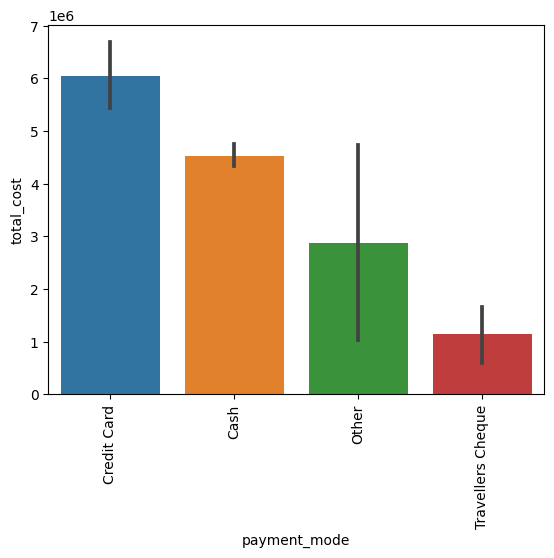

In [544]:
sns.barplot(df_tanzania_train, x="payment_mode", y="total_cost")
plt.xticks(rotation=90)

plt.show()

# People spend more if they pay with Credit Card

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Wildlife tourism'),
  Text(1, 0, 'Beach tourism'),
  Text(2, 0, 'Hunting tourism'),
  Text(3, 0, 'Mountain climbing'),
  Text(4, 0, 'Cultural tourism'),
  Text(5, 0, 'Conference tourism'),
  Text(6, 0, 'Bird watching'),
  Text(7, 0, 'business'),
  Text(8, 0, 'Diving and Sport Fishing')])

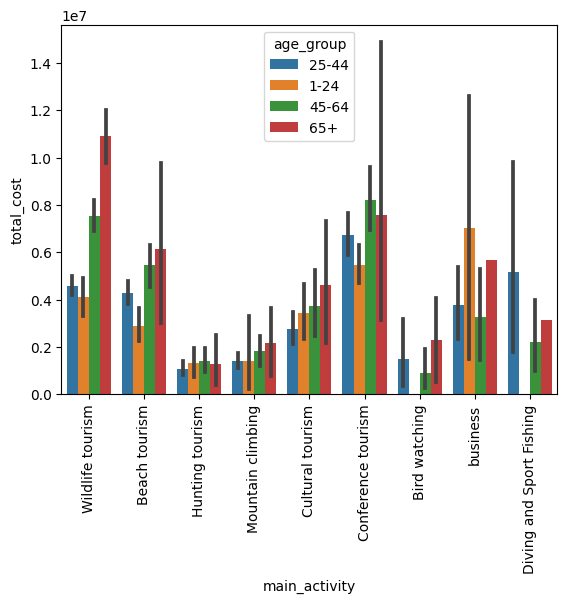

In [545]:
sns.barplot(df_tanzania_train, x="main_activity", y="total_cost", hue="age_group")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Meetings and Conference'),
  Text(1, 0, 'Leisure and Holidays'),
  Text(2, 0, 'Business'),
  Text(3, 0, 'Volunteering'),
  Text(4, 0, 'Visiting Friends and Relatives'),
  Text(5, 0, 'Other'),
  Text(6, 0, 'Scientific and Academic')])

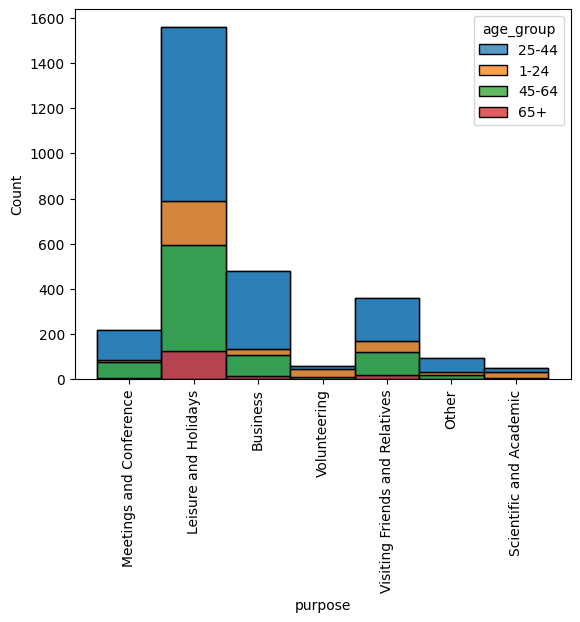

In [546]:
fig, ax = plt.subplots()
sns.histplot(data=df_tanzania_train, x="purpose",ax=ax)
sns.histplot(data=df_tanzania_train, x="purpose", hue="age_group", multiple="stack",ax=ax)
plt.xticks(rotation=90)

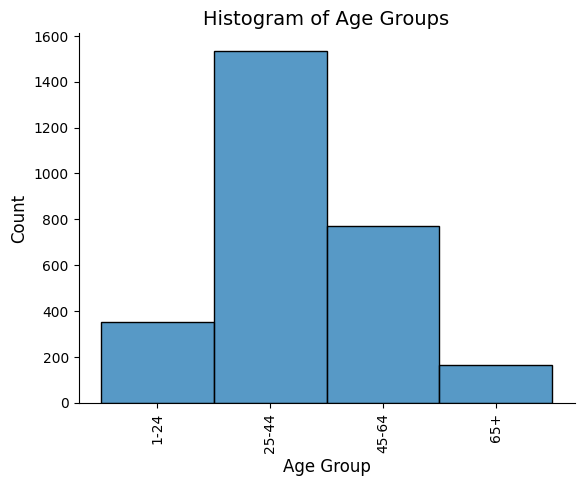

In [547]:
# <Reorganize the age_group and make it categorical

custom_order = ['1-24', '25-44', '45-64', "65+"] 


# Convert 'age_group' into a categorical variable with the custom order
df_tanzania_train['age_group'] = pd.Categorical(
    df_tanzania_train['age_group'], 
    categories=custom_order, 
    ordered=True
)

# Plot the histogram
sns.histplot(data=df_tanzania_train, x='age_group', stat='count', palette="viridis")

# Aesthetics
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Age Groups", fontsize=14)
plt.xticks(rotation=90)
sns.despine()


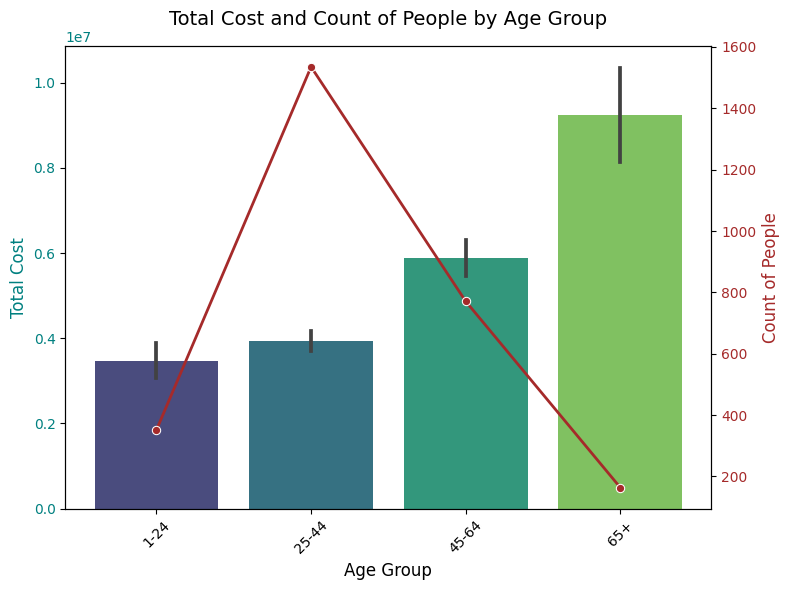

In [548]:
# Group by age_group to calculate total cost and counts
grouped = df_tanzania_train.groupby('age_group').agg(
    total_cost=('total_cost', 'sum'),
    count=('total_cost', 'count')
).reindex(['1-24', '25-44', '45-64', "65+"])  # Ensure custom order

# Create the figure and first y-axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart for total cost
sns.barplot(x=df_tanzania_train.age_group, y=df_tanzania_train.total_cost, ax=ax1, palette="viridis")
ax1.set_ylabel("Total Cost", fontsize=12, color="teal")
ax1.set_xlabel("Age Group", fontsize=12)
ax1.tick_params(axis='y', labelcolor="teal")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Total Cost and Count of People by Age Group", fontsize=14, pad=15)

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the line chart for the count of people
sns.lineplot(x=grouped.index, y=grouped['count'], ax=ax2, color="brown", marker="o", linewidth=2)
ax2.set_ylabel("Count of People", fontsize=12, color="brown")
ax2.tick_params(axis='y', labelcolor="brown")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Feature Engineering

### Imputation

In [549]:
# Impute empty values of "total_female" with rounded mean. 
# Impute empty values of "total_male" with rounded mean. 
# 
df_tanzania_train['total_female'].fillna(round(df_tanzania_train['total_female'].mean()), inplace=True)
df_tanzania_train['total_male'].fillna(round(df_tanzania_train['total_male'].mean()), inplace=True)

In [550]:
# Impute travel_with based on how many people they traveled with. If more than 1 - not alone. 

def travel_with_alone(row):
    travel_alone = row['travel_with']
    male = row['total_male']
    female = row['total_female']
    
    # Only process rows where 'travel_with' is NaN
    if pd.isnull(travel_alone):
        # Check if the person traveled alone
        if male == 1 and female == 0:  # One male, no females
            return "Alone"
        elif male == 0 and female == 1:  # One female, no males
            return "Alone"
        else:  # Any other combination means "Unknown"
            return "Unknown"
    else:
        # Keep the existing value if not NaN
        return travel_alone

In [551]:
# Apply the function to the DataFrame
df_tanzania_train['travel_with'] = df_tanzania_train.apply(travel_with_alone, axis=1)

# Check the number of "Unknown" values
unknown_count = (df_tanzania_train['travel_with'] == 'Unknown').sum()
print(f"Number of 'Unknown' entries: {unknown_count}")

# Check the number of 'Alone' entries for confirmation
alone_count = (df_tanzania_train['travel_with'] == 'Alone').sum()
print(f"Number of 'Alone' entries: {alone_count}")

# Verify that the number of missing values matches the sum of 'Alone' + 'Unknown'
processed_missing_count = unknown_count + alone_count
print(f"Total processed missing values (Alone + Unknown): {processed_missing_count}")

Number of 'Unknown' entries: 14
Number of 'Alone' entries: 1538
Total processed missing values (Alone + Unknown): 1552


### Encoding

In [552]:
#List of columns
col_encode = ['country', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement','payment_mode']
col_map = ['package_transport_int', 'package_accomodation', 'package_food','package_transport_tz', 'package_sightseeing', 'package_guided_tour','package_insurance','first_trip_tz',]
col_scale = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']

In [553]:
# Mapp all Yes/No features (col_map)

def mapping_tanzania(df,cols):
    df[cols] = df[cols].replace({'Yes': 1, 'No': 0}) 

mapping_tanzania(df_tanzania_train,col_map)

In [554]:
# Encode all categorical features (col_encode)

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohe.fit(df_tanzania_train[col_encode]) 
t = ohe.transform(df_tanzania_train[col_encode])

# Purpose: It generates the new feature names created during one-hot encoding, reflecting the original categorical feature and its unique values.
ohe.get_feature_names_out() 
df_tanzania_train_encode = pd.DataFrame(t, columns= ohe.get_feature_names_out())

# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_encode], axis=1)
df_tanzania_train.drop(columns=col_encode,inplace=True)

In [555]:
# Scale all numerical features (col_scale)

scaler = MinMaxScaler()
scaler.fit(df_tanzania_train[col_scale])
t = scaler.transform(df_tanzania_train[col_scale])
df_tanzania_train_scaled = pd.DataFrame(t, columns= scaler.get_feature_names_out())
df_tanzania_train_scaled.head()

# introduced into the frame
df_tanzania_train = pd.concat([df_tanzania_train.reset_index(drop=True), df_tanzania_train_scaled], axis=1)
df_tanzania_train.drop(columns=col_scale,inplace=True)

In [557]:
df_tanzania_train.shape

(2822, 130)

### Encoding - Pipeline / ColumnTransformer (WiP)

In [ ]:
# # Custom transformer for `travel_with`
# class TravelWithTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         # Apply the logic for `travel_with` as described
#         X = X.copy()
#         for index, row in X.iterrows():
#             if pd.isnull(row['travel_with']):
#                 male = row['total_male']
#                 female = row['total_female']
#                 if male == 1 and female == 0:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 elif male == 0 and female == 1:
#                     X.at[index, 'travel_with'] = 'Alone'
#                 else:
#                     X.at[index, 'travel_with'] = 'Unknown'
#         return X[['travel_with']]

#     def get_feature_names_out(self, input_features=None):
#         # Return the output column name for `travel_with`
#         return ['travel_with']

In [ ]:
# # Custom imputer transformer to round the mean
# class RoundedMeanImputer(TransformerMixin, BaseEstimator):
#     def fit(self, X, y=None):
#         self.means_ = X.mean().round()
#         return self

#     def transform(self, X):
#         return X.fillna(self.means_)
    
#     def get_feature_names_out(self, input_features=None):
#         # Return the same feature names as the input
#         return input_features

In [ ]:
# # ColumnTransformer with RoundedMeanImputer
# preprocessor = ColumnTransformer(
#     transformers=[
#         # Custom imputer for total_female and total_male using rounded mean
#         ('impute_num', RoundedMeanImputer(), ['total_female', 'total_male']),
        
#         # Map Yes/No features to 1/0 directly
#         ('map_binary', OneHotEncoder(drop='if_binary', sparse=False), col_map),

#         # Custom transformer for travel_with
#         ('custom_travel_with', TravelWithTransformer(), ['travel_with', 'total_male', 'total_female']),
        
#         # One-hot encode categorical features
#         ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), col_encode),
        
#         # Scale numerical features
#         ('scale', MinMaxScaler(), col_scale)
#     ],
#     remainder='passthrough'  # Keeps any columns not explicitly listed
# )

# # Full pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor)
# ])


In [ ]:
# # Fit and transform the data
# df_processed = pipeline.fit_transform(df_tanzania_train)

# # Convert to DataFrame
# output_columns = pipeline.named_steps['preprocessor'].get_feature_names_out()
# df_processed = pd.DataFrame(df_processed, columns=output_columns)

# # Verify results
# print("Shape of processed DataFrame:", df_processed.shape)
# print("Remaining NaN values:", df_processed.isna().sum().sum())

Shape of processed DataFrame: (2822, 137)
Remaining NaN values: 1


## Baseline Model

In [328]:
X_train = df_tanzania_train.drop("total_cost", axis=1)
y_train = df_tanzania_train["total_cost"]
